# [0] Imports

In [2]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

using Dates

# [1] Setup

## [1.1] Parameters

In [3]:
n_jobs = 25
n_vehicles_jobs = 25
n_vehicles_coverage = 10
T = 50
min_duration = 2
max_duration = 6
speed = 1000/6
coverage_distance = 50
size = 500
step = 50;

## [1.2] Locations, Windows, Loads

In [4]:
Random.seed!(1234)

function create_cluster_sizes(jobs_total)
    Random.seed!(1234)
    jobs_created = 0
    cluster = []
    while jobs_created != jobs_total
        num_to_add = rand(min(3, jobs_total - jobs_created) : 
            min(Int((n_jobs/5)÷1), jobs_total - jobs_created))
        jobs_created += num_to_add
        push!(cluster, num_to_add)
    end
    
    return cluster
end;

In [5]:
time_windows = []
locations = rand(Uniform(0,size), 1, 2)
work_load = []
cluster = create_cluster_sizes(n_jobs);

In [6]:
function create_time_windows_and_work_load(cluster_sizes, locations)
    Random.seed!(1234)
    locations = rand(Uniform(0,size), 1, 2)
    for size_c in cluster
        first = rand(Uniform(0,size), 1, 2)
        locations = vcat(locations, first)

        job_begins = rand(2:10)
        job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
        push!(time_windows, [job_begins, job_finish])

        time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
        push!(work_load, time_work)

        for neighbour in 1:(size_c-1)
            new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
            new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
            new = hcat(new_x, new_y)
            locations = vcat(locations, new)

            job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
            job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
            push!(work_load, time_work)
        end
    end
    
    return [time_windows, work_load, locations]
end;

In [7]:
time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

# [2] Helper Methods

## 2.1 Get initial routes

In [8]:
routes = []

for n in 1:n_jobs
    job_route = []
    dist = distances[1, n+1]

    min_t = Int(floor(time_windows[n][1] - dist/speed))
    max_t = Int(ceil(time_windows[n][2] + dist/speed))

    push!(job_route, [[0, min_t], [n, time_windows[n][1]], dist])
    
    for t in time_windows[n][1]:(time_windows[n][2]-1)
        push!(job_route, [[n, t], [n, t+1], 0])
    end
    
    push!(job_route, [[n, time_windows[n][2]], [n_jobs+1, max_t],  dist])
    push!(routes, job_route)
    
end

## 2.2 Compute Cost

In [9]:
function compute_cost(route)
    cost = 0
    for entity in route
        cost += entity[3]
    end
    return cost
end;

In [10]:
C = []
for i in 1:length(routes)
    push!(C, compute_cost(routes[i]))
end

## 2.3 Compute Delta

In [11]:
function compute_delta(routes)
    Q = length(routes)
    delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1, time1 = arc[1]
            loc2, time2 = arc[2]
            if (loc1 != 0) & (loc1 != n_jobs + 1)
                delta[loc1][time1][rindex] = 1
            end
            
            if (loc2 != 0) & (loc2 != n_jobs + 1)
                delta[loc2][time2][rindex] = 1
            end
        end
    end
    return delta
end;

In [12]:
delta = compute_delta(routes);

## 2.4 Compute U

In [13]:
function compute_u(routes)
    Q = length(routes)
    u = [[0 for q in 1:Q] for i in 1:n_jobs]
    
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1 = arc[1][1]
            loc2 = arc[2][1]
            if (1 <= loc1 <= n_jobs)
                u[loc1][rindex] = 1
            end
            if (1 <= loc2 <= n_jobs)
                u[loc2][rindex] = 1
            end
        end
    end
    return u
end;

In [14]:
u = compute_u(routes);

## 2.5 Label-Setting Algorithm

We've built this LSA to include multiple time-checking components. There are 5 places to check: 

1. The initial check for incrementing the current state
2. Feasibility check
3. Push new state if ...
4. Amend new state if ...
5. Check domination

Our goal is to figure out which of these steps consumes time.

In [16]:
function sp_lsa(n, travel_distance, travel_time, windows, load, rho_v, pi_v, mu_v)
    N = [[1]] 
    T = [ [0] ] 
    R = [rho_v]  
    L = [1]  
    A = [true] 
    
    current_state = 1
    total_state = 1
    times_burned = [ [], [], [], [], []]
    while 1==1
        t1 = datetime2unix(now())
        t2 = 0
        if (L[current_state] == n+2) | (~A[current_state])
            current_state += 1
            if current_state > total_state
                print(current_state, " ", total_state, " nothing more to check")
                t2 = datetime2unix(now())
                push!(times_burned[1], t2-t1)
                break
            else
                t2 = datetime2unix(now())
                push!(times_burned[1], t2-t1)
                continue
            end
        end
        t2 = datetime2unix(now())
        push!(times_burned[1], t2-t1)
        
        for i in 2:(n+2)
            
            if ~(i in N[current_state])

                t3 = datetime2unix(now())
                t4 = 0
                if L[current_state] != 1
                    cur_time = last(T[current_state])
                    dist_nec = travel_time[L[current_state], i]
                    old_job_time_nec = load[L[current_state]-1] #out of our parameters this one has no depot pad
                    new_job_time_nec = load[i-1]
                    new_window_close = windows[i-1][2]
                    
                    if cur_time + dist_nec + old_job_time_nec + new_job_time_nec > new_window_close
                        t4 = datetime2unix(now())
                        push!(times_burned[2], t4-t3)
                        continue
                    end
                end
                t4 = datetime2unix(now())
                push!(times_burned[2], t4-t3)

                if length(N) < total_state + 1

                    t5 = datetime2unix(now())
                    
                    push!(N, copy(N[current_state]))
                    push!(N[total_state+1], i)

                    cur_time = last(T[current_state])
                    dist_nec = travel_time[L[current_state], i]
                    old_job_time = L[current_state] > 1 ? load[L[current_state]-1] : 0
                    new_window_start = windows[i-1][1]
                    new_times_array = copy(T[current_state])
                    push!(new_times_array, max(cur_time + dist_nec + old_job_time, new_window_start))
                    push!(T, new_times_array)

                    add_segdist = travel_distance[L[current_state], i]
                    subtract_pi = i < n+2 ? -pi_v[i-1] : 0
                    subtract_mu = i < n+2 ? -mu_v[i-1, last(last(T))] : 0
                    push!(R, R[current_state] + add_segdist + subtract_pi + subtract_mu)
                    
                    push!(L, i)
                    
                    push!(A, true)
                    
                    t6 = datetime2unix(now())
                    push!(times_burned[3], t6-t5)
                    
                else
                    
                    t7 = datetime2unix(now())
                    N[total_state + 1] = N[current_state]
                    push!(N[total_state+1], i)
                    
                    cur_time = last(T[current_state])
                    dist_nec = travel_time[L[current_state], i]
                    old_job_time = L[current_state] > 1 ? load[L[current_state]-1] : 0
                    new_window_start = windows[i-1][1]
                    new_times_array = copy(T[current_state])
                    push!(new_times_array, max(cur_time + dist_nec + old_job_time, new_window_start))
                    T[total_state+1] = copy(new_times_array)
                    
                    add_segdist = travel_distance[L[current_state], i]
                    subtract_pi = i < n+2 ? -pi_v[i-1] : 0
                    subtract_mu = i < n+2 ? -mu_v[i-1, last(last(T))] : 0
                    R[total_state + 1] = R[current_state] + add_segdist + subtract_pi + subtract_mu
                    
                    L[total_state+1] = i
                    
                    A[total_state+1] = true
                    
                    t8 = datetime2unix(now())
                    push!(times_burned[4], t8-t7)
                end 
                
                t9 = datetime2unix(now())
                t10 = 0
                NDom = true
                for s in 1:total_state
                    if A[s]
                        if (issetequal(N[total_state+1], N[s])) & (L[total_state+1] == L[s])
                            if R[total_state+1] > R[s]
                                NDom = false
                                t10 = datetime2unix(now())
                                push!(times_burned[5], t10-t9)
                                break
                            else
                                A[s] = false
                            end
                        end
                    end
                end
                
                if NDom 
                    total_state += 1
                end
                
                t10 = datetime2unix(now())
                push!(times_burned[5], t10-t9)
        
            end
        end
        
        current_state += 1 # concluded iteration for that state in mind. Now next one

        if current_state == total_state
            print(current_state, " ", total_state, " came from bottom")
            break
        end     
    end
    
    return N, A, R, T, times_burned
end

sp_lsa (generic function with 1 method)

### 2.5.1 Label-Setting Algorithm Constant Variables

In [17]:
distances_label = deepcopy(distances)
distances_label = hcat(distances_label, distances_label[:, 1])
distances_label = vcat(distances_label, collect(push!(distances_label[:, 1], 0)'));

In [18]:
travel_times = ceil.(distances_label / speed);

In [19]:
windows_label = deepcopy(time_windows)
push!(windows_label, [0, 100]);

In [20]:
load_label = deepcopy(work_load)
push!(load_label, 0);

## 2.6 Extract Best Route in SP

In [21]:
function extract_best_route(sub_paths, sub_bool, sub_rc, sub_times)
    best_index = 1
    best_cost = 1

    for i in 1:length(sub_paths)

        ends_at_depot = (last(sub_paths[i]) == n_jobs + 2)
        negative_reduced_cost = (sub_rc[i] < -1e-5)
        time_fine = (last(sub_times[i]) <= T)

        if (ends_at_depot && negative_reduced_cost && time_fine && sub_bool[i])
            if sub_rc[i] < best_cost
                best_index = i
                best_cost = sub_rc[i]
            end
        end
    end

    if best_cost >= -1e-5
        println("We have concluded our column generation because nothing better is to be found!")
        println("The solution you found above is optimal.")
        return
    end
    
    return sub_paths[best_index], sub_rc[best_index], sub_times[best_index]
end;

## 2.7 Generate full time info on route

In [22]:
function generate_full_time_info(best_route, best_times)
    best_route_info = []
    for locindex in 1:length(best_route)-1
        #=
        Strategy:
        If you are not at a job location, you don't need to capture
        stationary information. Otherwise you do.

        Anyways we want data moving from one to the next.
        =#
        cur_loc = best_route[locindex]
        cur_time = best_times[locindex]
        time_to_start_moving = best_times[locindex]

        #stationary data comes first.
        if 1 < locindex < n_jobs + 2
            cur_job_num = cur_loc - 1 # delete padding!

            #stay stationary for however long it takes for you to do the job

            # Note: eventually this will have to be modified to include coverage.
            # Eventually we will write a subproblem-tells-us-when-work-is-done component.

            for time in cur_time:cur_time+work_load[cur_job_num]-1
                route_detail = [ [cur_loc-1, time], [cur_loc-1, time+1], 0]
                push!(best_route_info, route_detail)
            end

            time_to_start_moving += work_load[cur_job_num]
        end

        new_loc = best_route[locindex+1]
        #then if we move, we move.
        route_detail = [ [cur_loc-1, time_to_start_moving], [new_loc-1, best_times[locindex+1]], distances_label[cur_loc, new_loc]]
        push!(best_route_info, route_detail)
    end

    return best_route_info
end;

# [3] Column Generation Loop

## [3.1] Initial Run

### [3.1.1] Run RMP

In [23]:
modelcg = Model(Gurobi.Optimizer);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [24]:
Q = length(routes)

25

In [25]:
unregister(modelcg, :z)
unregister(modelcg, :y_s)
unregister(modelcg, :y_e)
@variable(modelcg, 0 <= z[1:Q] <= 1) # should be Bin
@variable(modelcg, 0 <= y_s[1:n_jobs, 1:T] <= 1) # should be Bin
@variable(modelcg, 0 <= y_e[1:n_jobs, 1:T] <= 1); # should be Bin

In [26]:
unregister(modelcg, :unique)
@constraint(modelcg, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);

In [27]:
unregister(modelcg, :driver)
@constraint(modelcg, driver, sum(z[q] for q in 1:Q) <= n_vehicles_jobs)

unregister(modelcg, :start)
unregister(modelcg, :ends)
@constraint(modelcg, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(modelcg, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
unregister(modelcg, :window_start)
unregister(modelcg, :window_ends)
@constraint(modelcg, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] == 0)
@constraint(modelcg, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] == 1)
unregister(modelcg, :duration)
@constraint(modelcg, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
unregister(modelcg, :work)
@constraint(modelcg, work[i in 1:n_jobs, t in 1:(T-1)], 
    y_s[i, t] - y_e[i, t] <= sum(z[q] * delta[i][t][q] for q in 1:Q));

In [28]:
unregister(modelcg, :coverage)
@constraint(modelcg, coverage[i in 1:n_jobs, t in 1:T], y_s[i, t] - y_e[i, t] <= 1);

In [29]:
@objective(modelcg, Min, sum(compute_cost(routes[q]) * z[q] for q in 1:Q));

In [30]:
optimize!(modelcg)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6126 rows, 2525 columns and 13675 nonzeros
Model fingerprint: 0x5861736b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 6126 rows and 2525 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2940985e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.294098475e+03

User-callback calls 121, time in user-callback 0.00 sec


### [3.1.2] Get Dual Variables

In [31]:
pi_values = dual.(unique)
rho_value = dual.(driver)
mu_values = dual.(work);

### [3.1.3] Time Analysis (Use Subproblem LSA)

In [33]:
time_1 = datetime2unix(now())
sub_paths, sub_bool, sub_rc, sub_times, tanal = sp_lsa(n_jobs, distances_label, travel_times, windows_label, load_label, rho_value, pi_values, mu_values);
time_2 = datetime2unix(now())

16577 16576 nothing more to check

1.689687759359e9

This is the time the algorithm took in total.

In [34]:
time_2-time_1

71.99699997901917

Now let's see how many times we passed through each check.

In [38]:
for i in 1:5
    println(length(tanal[i]))
end

16576
177614
16575
0
16575


Looks like there was never an invalid route (i.e. nothing was dominated). Also, there 10.71 times as many checks in the second place (check feasibility) as opposed to everywhere else. This makes sense because a lot of i nodes will not be feasible, but we will have used time to check that quality.

Checking the first place: see if we increment current state. Not much time used.

In [41]:
println("Time burned on checking the first: ", sum(tanal[1]))
for i in 1:length(tanal[1])
    if tanal[1][i] > 1e-10
        println(i, " ", tanal[1][i])
    end
end

Time burned on checking the first: 0.03299975395202637
545 0.0009999275207519531
13003 0.0010001659393310547
13501 0.0009999275207519531
14678 0.0009999275207519531
14995 0.0009999275207519531
16576 0.0279998779296875


Checking the second place: feasibility check. Similarly, not much time was used!

In [42]:
println("Time burned on checking feasibility (Second): ", sum(tanal[2]))

Time burned on checking feasibility (Second): 0.08800005912780762


It would be cool if we could get a graph of this.

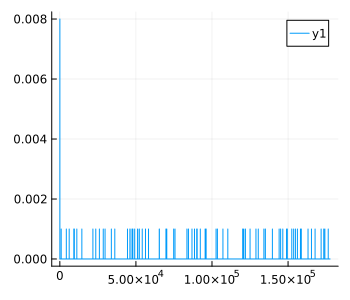

In [44]:
plot([i for i in 1:length(tanal[2])], tanal[2], seriestype=:line, legend=:topright, size = (350, 300))

Checking the third: It happened 16575 times. Is this the bottleneck?

In [45]:
println("Time burned on third push route: ", sum(tanal[3]))

Time burned on third push route: 0.05199909210205078


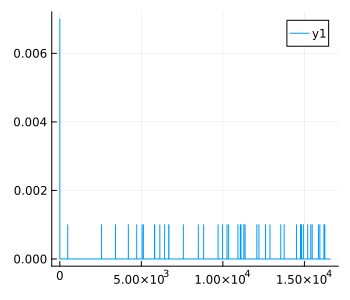

In [46]:
plot([i for i in 1:length(tanal[3])], tanal[3], seriestype=:line, legend=:topright, size = (350, 300))

Average time used for each check?

In [47]:
0.052 / 16576

3.1370656370656368e-6

So none of these three are the culprit. The 4th section, replacing data, likely takes a similar amount of time if it actually happened once. But it didn't.

In [48]:
println("Time burned on n-domination check: ", sum(tanal[5]))

Time burned on n-domination check: 71.44500255584717


This is the culprit and the true bottleneck! What does time graph look like? I believe it will be superlinear because we check more nodes *that become more size-large*.

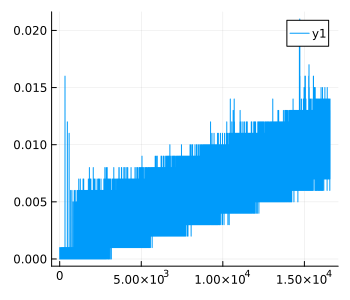

In [53]:
plot([i for i in 1:length(tanal[5])], tanal[5], seriestype=:line, legend=:topright, size = (350, 300))

How about a cumulative graph? This looks cool.

In [56]:
cum_sum = [0.0]
for i in 1:length(tanal[5])
    push!(cum_sum, cum_sum[i] + tanal[5][i])
end
cum_sum = cum_sum[2:end];

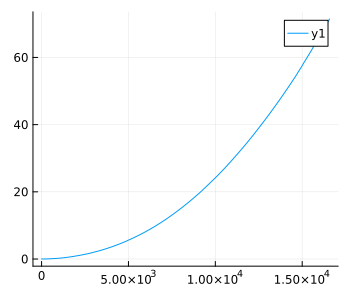

In [57]:
plot([i for i in 1:length(tanal[5])], cum_sum, seriestype=:line, legend=:topright, size = (350, 300))

Draw cumulative graphs for #1 #2 and #3 now.

In [62]:
cum_sums = [[0.0], [0.0], [0.0]]
for graph_choice in 1:3
    for i in 1:length(tanal[graph_choice])
        push!(cum_sums[graph_choice], cum_sums[graph_choice][i] + tanal[graph_choice][i])
    end
    
    cum_sums[graph_choice] = cum_sums[graph_choice][2:end]
end

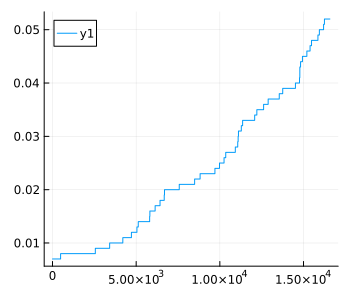

In [68]:
plot([i for i in 1:length(tanal[3])], cum_sums[3], seriestype=:line, legend=:topleft, size = (350, 300))

### [3.1.4] Extract the best route with most negative reduced cost

In [468]:
best_route, best_rc, best_times = extract_best_route(sub_paths, sub_bool, sub_rc, sub_times);

### [3.1.5] Generate full time info on best route

In [469]:
best_route_info = generate_full_time_info(best_route, best_times);

### [3.1.6] Add best route info to Q

In [470]:
push!(routes, best_route_info);

### [3.1.7] Update Parameters

In [471]:
u = compute_u(routes)
delta = compute_delta(routes);

In [472]:
C = []
for i in 1:length(routes)
    push!(C, compute_cost(routes[i]))
end;